# Open-cell tests

In [1]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as font_manager
from ipywidgets import interact, fixed, interact_manual
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

In [2]:
# custom
import sys
sys.path.append('../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

/home/labuser/miniconda3/envs/for_work/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


HAPI version: 1.2.2.4
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

# Test paths

In [3]:
ps = ["./" + i + "/" for i in cp.dir_match("./", "bypass")]
ps

['./bypass_0/',
 './bypass_1000/',
 './bypass_5/',
 './bypass_5_short/',
 './bypass_5_short_redo/']

# Manual operations

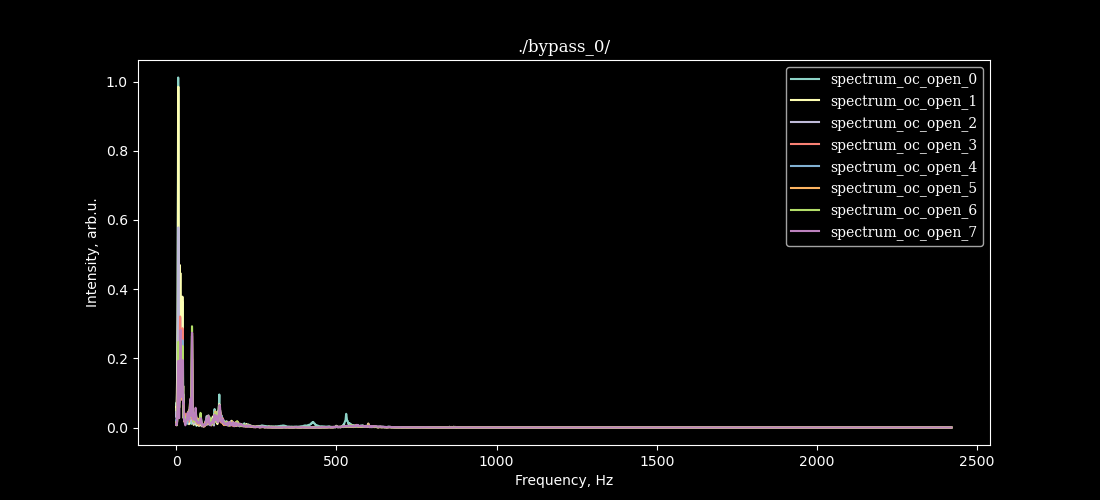

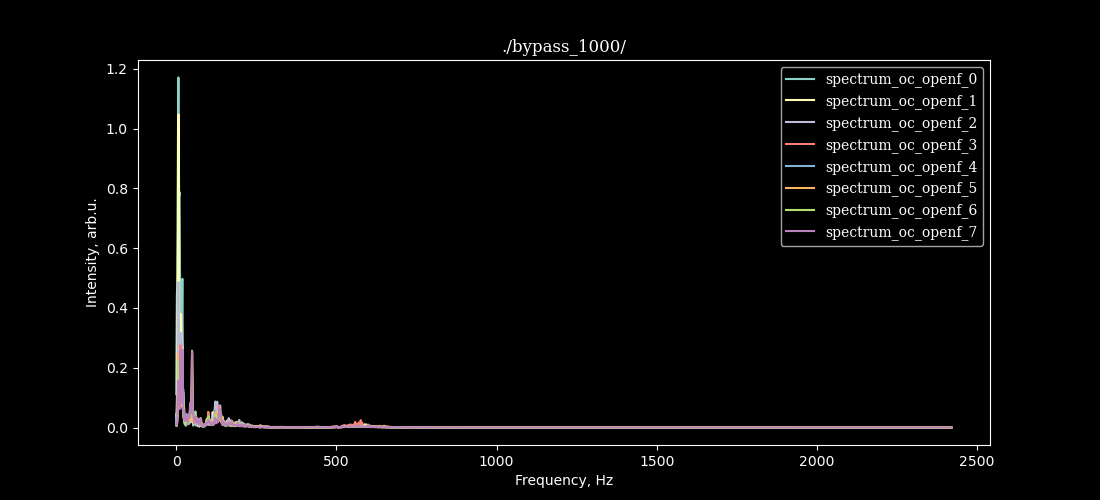

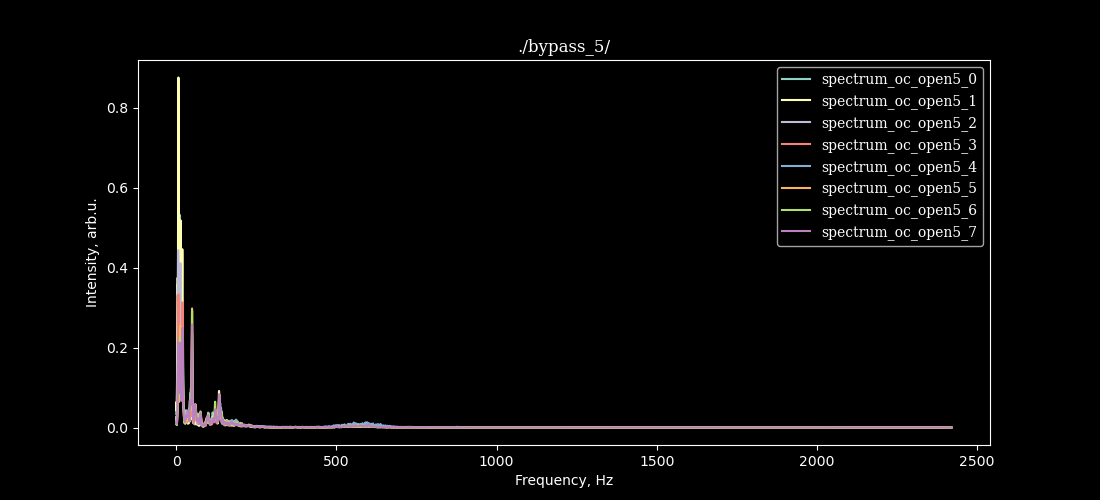

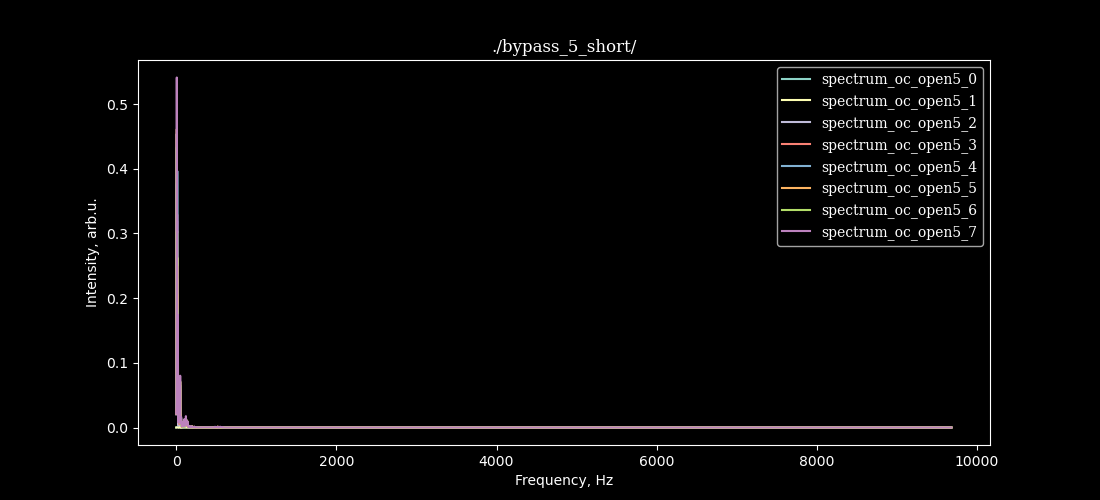

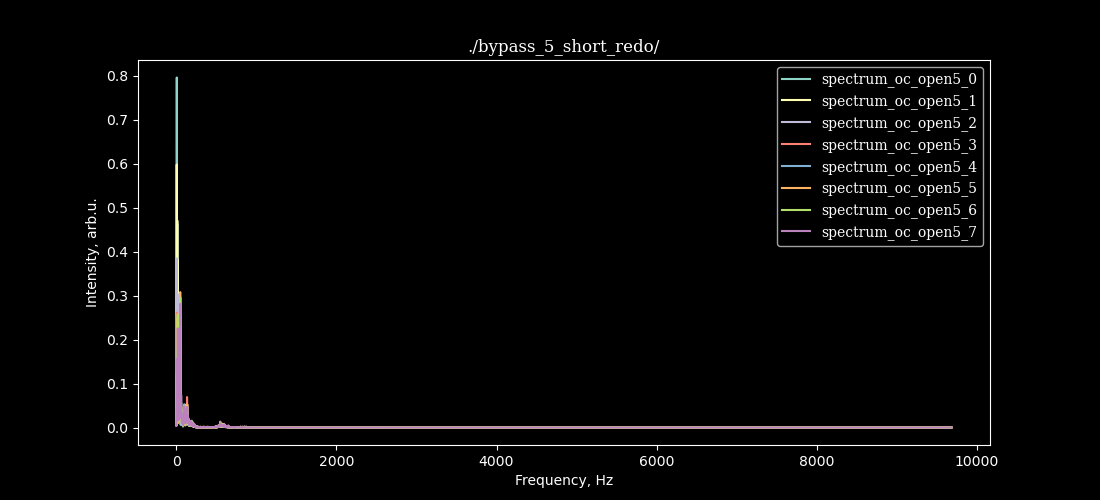

In [6]:
%matplotlib widget




ps_dict = {ps[i]: cp.dir_match(ps[i], "spectrum_oc") for i in range(len(ps))}
# print(ps_dict)
plt.close()
for p_idx in range(len(ps)):
    values = list(ps_dict.values())
    # print(values)
    dfs_dict = {
        item[:-4]: pd.read_csv(ps[p_idx] + item,
                                    sep="\\s+",
                                    header=None,
                                    names=['Frequency', 'Intensity']
                                    ) for item in values[p_idx]}
    dfs_list = list(dfs_dict.values())
    dfs_keys = list(dfs_dict.keys())
    # print(dfs_list[0])

    plt.figure(figsize=(11, 5))

    font = font_manager.FontProperties(family='serif')

    for idx in range(len(dfs_list)):
        plt.plot(dfs_list[idx]['Frequency'],
                dfs_list[idx]['Intensity'],
                label=f"{dfs_keys[idx]}")
        plt.xlabel("Frequency, Hz")
        plt.ylabel("Intensity, arb.u.")
        plt.legend(prop=font)
    


    plt.title(ps[p_idx], fontname='serif')
    plt.show()

## Integrals

[0, 1, 2, 3, 4, 5, 6, 7]


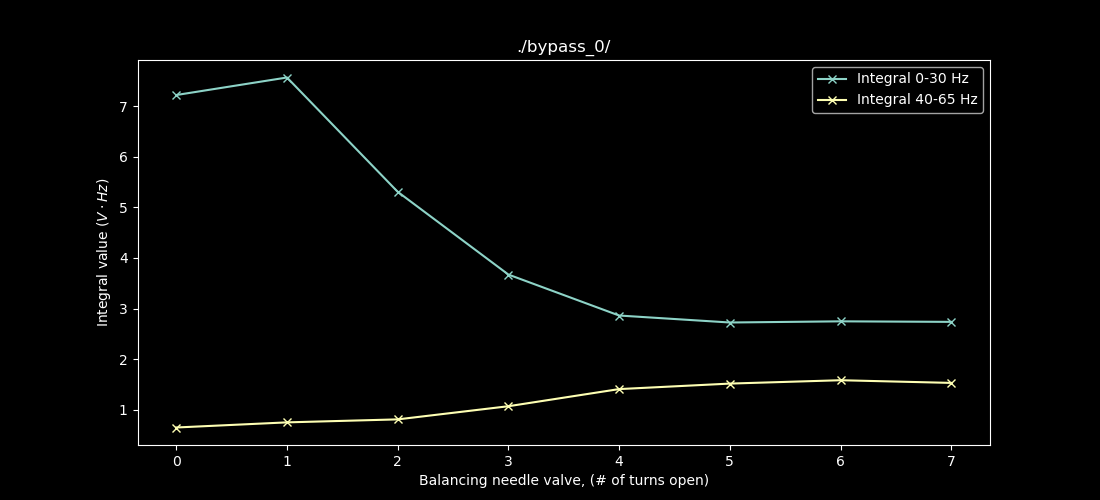

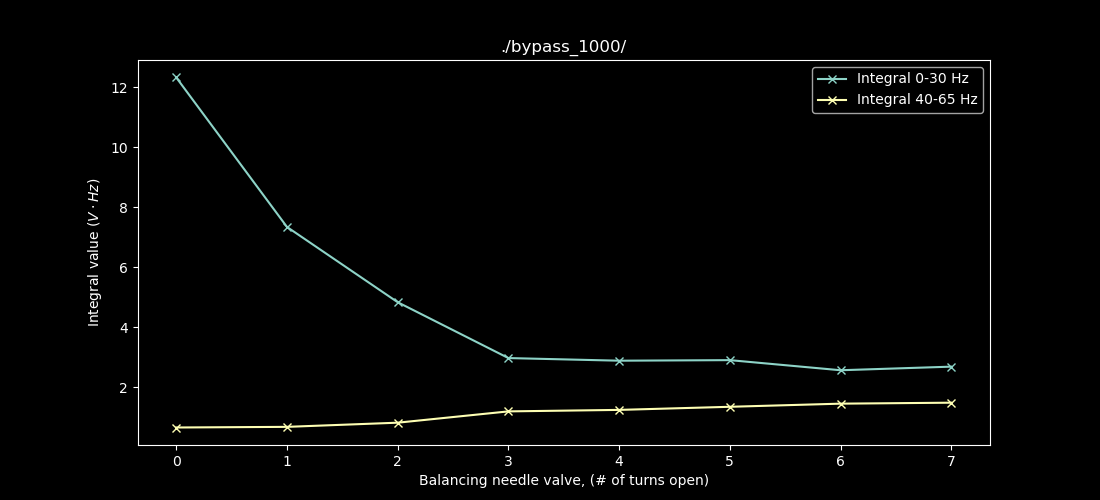

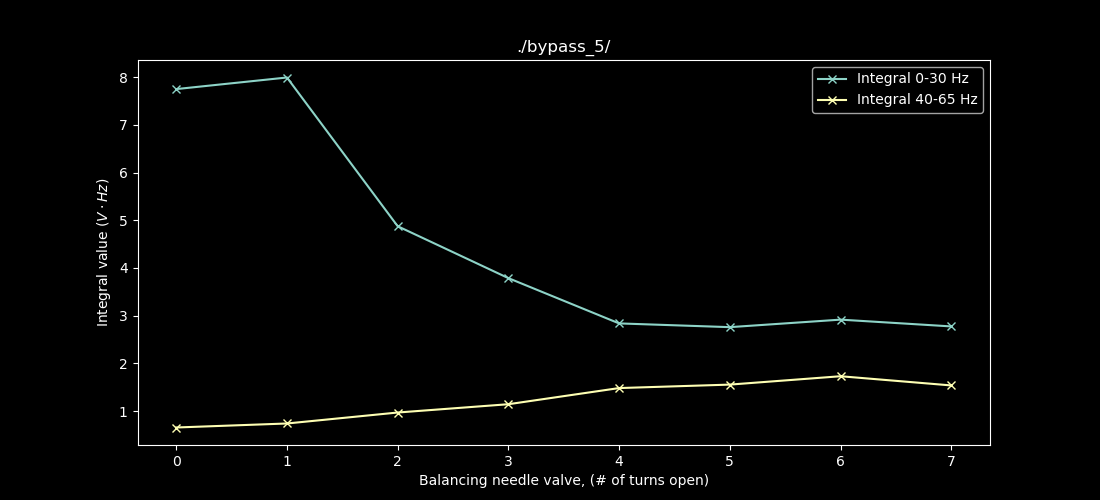

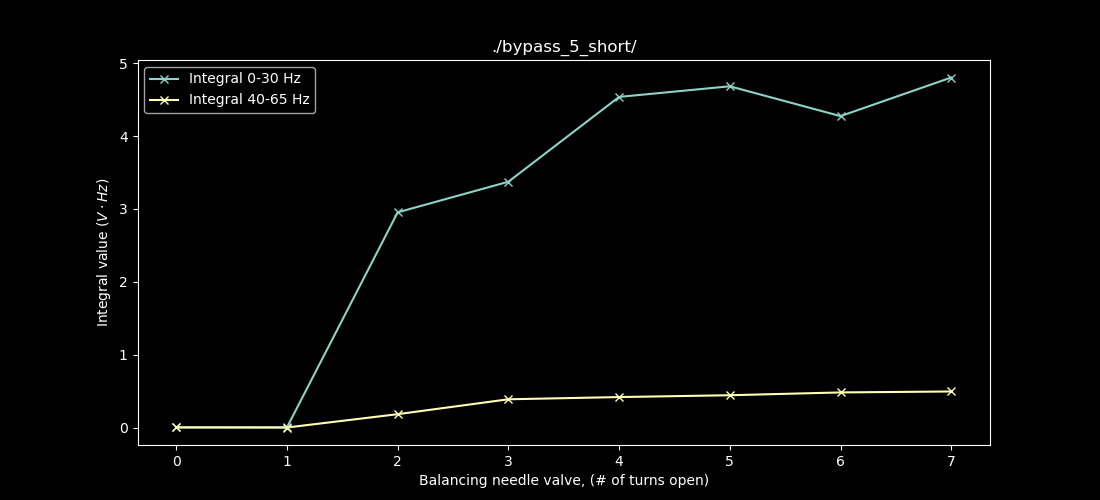

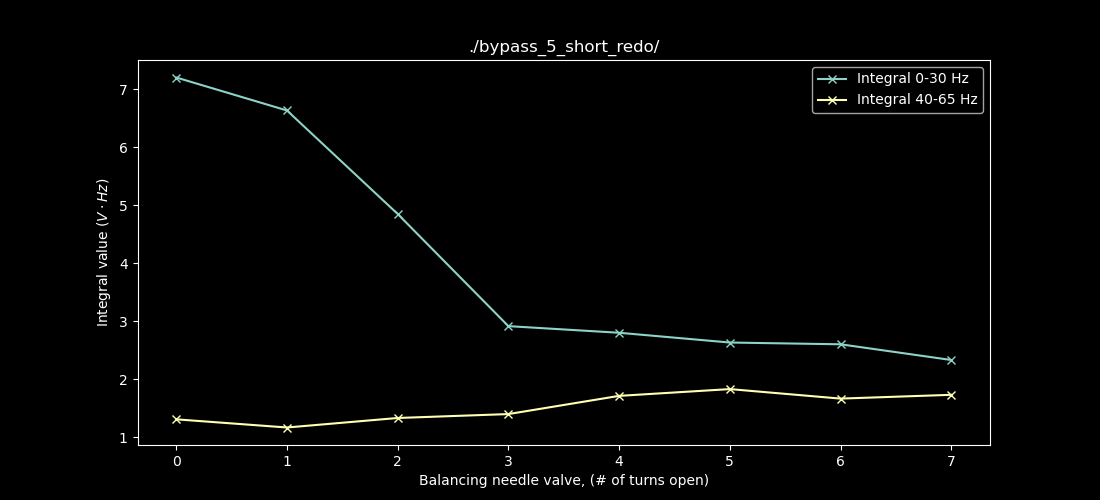

In [11]:
s = [0, 40]
f = [30, 65]

bypass_max = 7
bypass_amounts = list(range(bypass_max+1))
print(bypass_amounts)

plt.close()
for p_idx in range(len(ps)):
    values = list(ps_dict.values())
    # print(values)
    dfs_dict = {
        item[:-4]: pd.read_csv(ps[p_idx] + item,
                                    sep="\\s+",
                                    header=None,
                                    names=['Frequency', 'Intensity']
                                    ) for item in values[p_idx]}
    dfs_list = list(dfs_dict.values())

    integral1 = [
        cp.integrate_range_of(
            df, s[0], f[0], 'Frequency', 'Intensity') for df in dfs_list]
    integral2 = [
        cp.integrate_range_of(
            df, s[1], f[1], 'Frequency', 'Intensity') for df in dfs_list]

    df_integrals = pd.DataFrame({
        'Bypass': bypass_amounts,
        f'Integral {s[0]}-{f[0]} Hz': integral1,
        f'Integral {s[1]}-{f[1]} Hz': integral2
    })

    plt.figure(figsize=(11, 5))


    plt.plot(df_integrals['Bypass'], df_integrals.iloc[:,1], marker='x', label=f"{df_integrals.iloc[:,1].name}")
    plt.plot(df_integrals['Bypass'], df_integrals.iloc[:,2], marker='x', label=f'{df_integrals.iloc[:,2].name}')

    plt.xlabel("Balancing needle valve, (# of turns open)")
    plt.ylabel("Integral value ($V \\cdot Hz$)")

    plt.legend()
    plt.title(ps[p_idx])

    plt.show()